1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


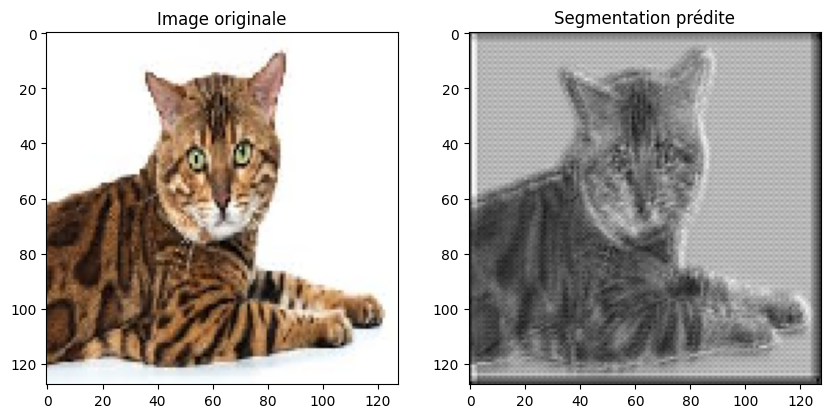

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Définition du modèle U-Net
def unet(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encodeur
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Décodeur
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4], axis=3)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3], axis=3)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2], axis=3)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Exemple d'entraînement avec un jeu de données personnalisé
# Assurez-vous que votre jeu de données est dans le format approprié

# Charger vos images et masques d'entraînement
# images_train, masks_train = ... (Chargez ici vos images et masques d'entraînement)

# images_train = images_train / 255.0  # Normalisation des images

# Créer le modèle U-Net
model = unet(input_size=(128, 128, 3))

# Entraîner le modèle (exemple)
# model.fit(images_train, masks_train, batch_size=32, epochs=10, validation_split=0.1)

# Sauvegarder le modèle si besoin
# model.save("unet_model.h5")

# Prédiction sur une image de test
def predict_and_plot(image_path):
    # Charger et prétraiter l'image de test
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0  # Normalisation de l'image
    img_array = np.expand_dims(img_array, axis=0)

    # Prédiction
    prediction = model.predict(img_array)
    prediction = np.squeeze(prediction, axis=0)  # Retirer la dimension supplémentaire

    # Visualiser le résultat
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image originale")

    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='gray')
    plt.title("Segmentation prédite")

    plt.show()




# Chemin de l'image de test
image_path = 'images.jpeg'

# Prédiction et visualisation
predict_and_plot(image_path)


# Perform semantic segmentation with a pretrained DeepLabv3+ model

In [1]:
!pip install keras==3.0.0 # downgrade keras to 3.0.0
!pip install keras-cv

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"

In [3]:
import keras
from keras import ops

import keras_cv
import numpy as np

from keras_cv.datasets.pascal_voc.segmentation import load as load_voc

In [4]:
model = keras_cv.models.DeepLabV3Plus.from_preset(
    "deeplab_v3_plus_resnet50_pascalvoc",
    num_classes=21,
    input_shape=[512, 512, 3],
)

100%|██████████| 10.5k/10.5k [00:00<00:00, 12.9MB/s]


100%|██████████| 150M/150M [00:04<00:00, 38.0MB/s]


80458/80458 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step


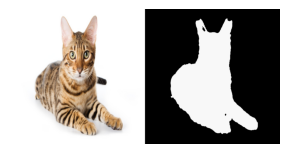

In [9]:
filepath = keras.utils.get_file(origin="https://www.veterinairesaintbernard.com/Uploads/conseils/Bengalshutterstock_34752745.jpg-800.JPG")
image = keras.utils.load_img(filepath)

resize = keras_cv.layers.Resizing(height=512, width=512)
image = resize(image)
image = keras.ops.expand_dims(np.array(image), axis=0)
preds = ops.expand_dims(ops.argmax(model(image), axis=-1), axis=-1)
keras_cv.visualization.plot_segmentation_mask_gallery(
    image,
    value_range=(0, 255),
    num_classes=1,
    y_true=None,
    y_pred=preds,
    scale=3,
    rows=1,
    cols=1,
)